In [1]:
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import inspect

In [2]:
med_wotargeting = pd.read_csv('shemesh_scraped_data_supplementary_fig9/David_2_left_median.txt', 
                              delimiter=';',decimal=',',names=['x','y']).round(dict(x=0))
quart_wotargeting = pd.read_csv('shemesh_scraped_data_supplementary_fig9/David_2_left_quartiles.txt', 
                                delimiter=';',decimal=',',names=['x','y']).round(dict(x=0))
med_wtargeting = pd.read_csv('shemesh_scraped_data_supplementary_fig9/David_2_right_median.txt', 
                             delimiter=';',decimal=',',names=['x','y']).round(dict(x=0))
quart_wtargeting = pd.read_csv('shemesh_scraped_data_supplementary_fig9/David_2_right_quartiles.txt', 
                               delimiter=';',decimal=',',names=['x','y']).round(dict(x=0))
# transform quartile positions into quartile range for error estimation
err_est_wotargeting = pd.DataFrame(quart_wotargeting.groupby(['x'])['y'].diff()).assign(x=quart_wotargeting['x'].values).dropna()
err_est_wtargeting = pd.DataFrame(quart_wtargeting.groupby(['x'])['y'].diff()).assign(x=quart_wtargeting['x'].values).dropna()

/home/david/Software/miniconda3/envs/mioos/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until


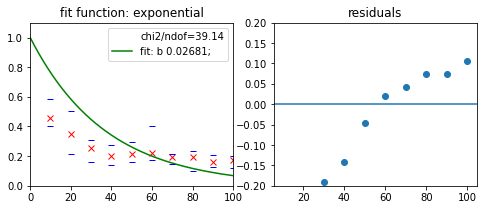

chi2: 352.24775126436964 ndof 9
popt: [0.02680779]


/home/david/Software/miniconda3/envs/mioos/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in exp
  


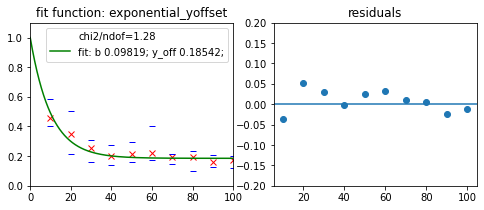

chi2: 10.271804405906185 ndof 8
popt: [0.0981902  0.18541666]


/home/david/Software/miniconda3/envs/mioos/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: overflow encountered in exp
  if sys.path[0] == '':


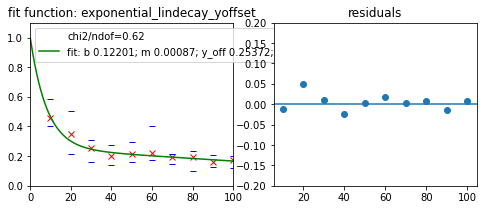

chi2: 4.348217506007517 ndof 7
popt: [0.12200722 0.00086746 0.25372019]


In [3]:
# fit fuctions
def exponential(x, b):
    return np.exp(-b*x)

def exponential_yoffset(x, b, y_off):
    return (1 - y_off) * np.exp(-b*x) + y_off

def exponential_lindecay(x, b, m):
    return np.exp(-b*x) - m * x

def exponential_lindecay_yoffset(x, b, m, y_off):
    return (1-y_off) * np.exp(-b*x) - m * x + y_off

def res_chi2(xdata, ydata, sigma, popt, fit_func):
    r = ydata - fit_func(xdata, *popt)
    chisq = sum((r / sigma) ** 2)
    return r, chisq

# utility
def fit(fitfunc, xdata, ydata, sigma,quartiles):
    fitparams = inspect.getfullargspec(fitfunc)[0][1:]
    ndof = len(ydata)-len(fitparams)
    popt, pcov = curve_fit(
        f=fitfunc,
        xdata=xdata,
        ydata=ydata,
        sigma=sigma,
        p0=None, absolute_sigma=False)
    # standard error on the mean is sigma / sqrt(N) with sample size N
    # if we take the median as estimator for the mean then its error is
    sigma_mean = sigma / np.sqrt(9) # 9 samples (neurites) 
    res, chi2 = res_chi2(xdata, ydata, sigma_mean, popt, fitfunc)

    xplot = np.linspace(0,100,1000)    
    fig, [ax1,ax2] = plt.subplots(ncols=2, figsize=(8,3))
    ax1.set_title('fit function: '+fitfunc.__name__)
    ax1.plot([1],[10],linestyle='',label='chi2/ndof=%1.2f'%(chi2/ndof))
    ax1.plot(xdata, ydata,'rx')
    ax1.plot(xplot, fitfunc(xplot,*popt), 'g-',
             label='fit: '+' '.join([param +' %2.5f;'%val for param,val in zip(fitparams, popt)]))
    ax1.plot(quartiles.x, quartiles.y,'b_')
    ax1.set_xlim(0,100)
    ax1.set_ylim(0,1.1)
    ax1.legend()

    ax2.plot(xdata, res, marker='o',linestyle='')
    ax2.axhline([0])
    ax2.set_title('residuals')
    ax2.set_ylim(-0.2,0.2)
    plt.show()
    print('chi2:',chi2,'ndof',ndof)
    print('popt:', popt)

    

# exponential
fit(fitfunc=exponential, 
    xdata=med_wtargeting.x[1:].values,
    ydata=med_wtargeting.y[1:].values,
    sigma=err_est_wtargeting.y/2, # estimate sigma based on the range between 1st and 3rd quartile (25 to 75) / 2
    quartiles=quart_wtargeting)

# exponential with y-offset
fit(fitfunc=exponential_yoffset, 
    xdata=med_wtargeting.x[1:].values,
    ydata=med_wtargeting.y[1:].values,
    sigma=err_est_wtargeting.y/2,
    quartiles=quart_wtargeting)

# exponential with y-offset and lin decay
fit(fitfunc=exponential_lindecay_yoffset, 
    xdata=med_wtargeting.x[1:].values,
    ydata=med_wtargeting.y[1:].values,
    sigma=err_est_wtargeting.y/2,
    quartiles=quart_wtargeting)

print("Note: The fit parameters are not automatically transferred to the ChR2 distribution function which is located in base-optostim/optostim/cell.py")